# Geospatial Analysis of Uber TLC FOIL Data
#### By Louis Jarvis
## Dependencies

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd #high-performance, easy-to-use data structures and data analysis tools
import geopandas #extends the datatypes used by pandas to allow spatial operations on geometric types
import mapclassify as mc #Classification schemes for choropleth mapping
import warnings
import joblib
import multiprocessing
import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error
from multiprocessing import cpu_count
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from shapely.geometry import Point, Polygon
from datetime import timedelta
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.display.max_rows = 200
warnings.filterwarnings('ignore')

## Custom functions definition

In [2]:
#For plotting ride data throughout the notebook
def plotRides(x, y, neighborhood, month):
    plt.figure(figsize=(15,10))
    plt.plot_date(x, y, '.', xdate=True, linestyle = '-')
    plt.tick_params(length=6, width=2)
    plt.axis([np.min(x), np.max(x), np.min(y), np.max(y)])
    plt.xlabel('DateTime')
    plt.ylabel('Number of Rides')
    plt.title('Uber Rides in the ' + neighborhood + ' Neighborhood (' + month + ')')
    plt.show()

#For plotting a map of the selected neighborhood
def plotNeighborhood(neighborhood):
    ax = neighborhoods.plot(edgecolor='k', facecolor='none', figsize=(15, 15))
    ax.set(xlim=(-74.3, -73.6), ylim=(40.4, 41))
    ridesJoinNeighborhood[ridesJoinNeighborhood['neighborhood'] == neighborhood].plot(ax=ax, color='blue')

# sarima_forecast() will fit a model with a given configuration and make a one-step forecast
def sarima_forecast(history, config):
    order, sorder = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# train_test_split() function below implements this for a provided dataset and a specified number of time steps to use in the test set
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# The measure_rmse() function below will calculate the RMSE given a list of actual (the test set) and predicted values
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    test = test.reset_index(drop=True)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > ' + 
              datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + 
              ' Model[%s] %.3f' % (key, result)
             )
    return (key, result)

# create a set of all sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m)]
                                models.append(cfg)
    return models

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, True) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

## Importing & Formatting Uber TLC FOIL Ride Data
**rides**
* Contains a list of all rides initiated in the New York City (NYC) area in September of 2014 in a GeoPandas GeoDataFrame
* Only September 2014 data was considered in this analysis due to computational resource constraints
* Pickup time stamps (*pickupDateTime*) were rounded down to the nearest hour
* *geometry* describes the ride's pickup location as a geodata CRS point

In [3]:
rides = pd.read_csv("./data/uber-raw-data-sep14.csv").pipe(geopandas.GeoDataFrame)
rides['Date/Time'] = pd.to_datetime(rides['Date/Time'])
rides['pickupDateTime'] = pd.to_datetime(rides['Date/Time'].dt.strftime("%Y-%m-%d %H:00:00"))
rides['geometry'] = list(zip(rides.Lon.astype(float), rides.Lat.astype(float)))
rides['geometry'] = rides['geometry'].apply(Point)
rides =  rides.drop(columns=['Lat', 'Lon', 'Base'])
rides.head()

,Date/Time,pickupDateTime,geometry
0,2014-09-01 00:01:00,2014-09-01,POINT (-74.0021 40.2201)
1,2014-09-01 00:01:00,2014-09-01,POINT (-74.0027 40.75)
2,2014-09-01 00:03:00,2014-09-01,POINT (-73.9864 40.7559)
3,2014-09-01 00:06:00,2014-09-01,POINT (-73.9889 40.745)
4,2014-09-01 00:11:00,2014-09-01,POINT (-73.9444 40.8145)


**neighborhoods**
* A GeoDataFrame dataset that describe the physical boundries (in CRS polygons) of distinct neighborhoods within New York City
* Will be used for grouping of ride pickup coordinates into discrete *locations*

In [4]:
neighborhoods = geopandas.read_file("./data/Neighborhood_Tabulation_Areas.geojson")
neighborhoods.crs = rides.crs
neighborhoods = neighborhoods.rename(index=str, columns={"ntaname": "neighborhood"})
neighborhoods = neighborhoods.rename(index=str, columns={"boro_name": "borough"})
neighborhoods = neighborhoods.drop(columns=['ntacode', 'shape_area', 'county_fips', 'shape_leng', 'boro_code'])
neighborhoods.head()

,neighborhood,borough,geometry
0,Borough Park,Brooklyn,(POLYGON ((-73.97604935657381 40.6312759056467...
1,Murray Hill,Queens,(POLYGON ((-73.80379022888246 40.7756101117924...
2,East Elmhurst,Queens,(POLYGON ((-73.86109724335759 40.7636644770869...
3,Hollis,Queens,(POLYGON ((-73.75725671509139 40.7181386016625...
4,Manhattanville,Manhattan,(POLYGON ((-73.94607828674226 40.8212632160619...


## Initial Data Analysis  
**ridesJoinNeighborhood** - Associating ride pickup coordinates with neighborhoods 
* By using geopandas sjoin function, we are able to match the pickup location of each ride with the neighborhood in which the ride was initiated
* This information is used to group the series of ride pickup CRS coordinates into distinct *locations* (i.e., neighborhoods).

In [5]:
ridesJoinNeighborhood = geopandas.sjoin(rides, neighborhoods, op='within', how='left')
ridesJoinNeighborhood.head()

,Date/Time,pickupDateTime,geometry,index_right,neighborhood,borough
0,2014-09-01 00:01:00,2014-09-01,POINT (-74.0021 40.2201),NaN,NaN,NaN
1,2014-09-01 00:01:00,2014-09-01,POINT (-74.0027 40.75),159,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan
2,2014-09-01 00:03:00,2014-09-01,POINT (-73.9864 40.7559),100,Midtown-Midtown South,Manhattan
3,2014-09-01 00:06:00,2014-09-01,POINT (-73.9889 40.745),159,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan
4,2014-09-01 00:11:00,2014-09-01,POINT (-73.9444 40.8145),136,Central Harlem North-Polo Grounds,Manhattan


**ridesPerNeighborhood** - Aggregating ride data by neighborhood, hour
* *ridesPerNeighborhood* groups and counts the number of rides that were initiated in each neighborhood per hour from *ridesJoinNeighborhood*

In [6]:
ridesPerNeighborhood = ridesJoinNeighborhood.rename(index=str, columns={"Date/Time": "count"}).groupby(['pickupDateTime','neighborhood'], as_index=False)[['count']].count()
ridesPerNeighborhood.head()

,pickupDateTime,neighborhood,count
0,2014-09-01,Airport,6
1,2014-09-01,Astoria,8
2,2014-09-01,Battery Park City-Lower Manhattan,13
3,2014-09-01,Bay Ridge,4
4,2014-09-01,Bayside-Bayside Hills,1


**Choosing a neighborhood to forecast**
* The analysis will be performed per neighborhood due to the difference in seasonality across different neighborhoods (e.g., commercial centers experience different hours of peak activity relative to residential areas)
* We will forecast the number of pickups per hour over the month of October 2014 for a specific, selected neighborhood
  
*Execute the following line to see a list of all NYC neighborhoods*

In [7]:
print(neighborhoods['neighborhood'].sort_values())

128                                              Airport
33                               Allerton-Pelham Gardens
97            Annadale-Huguenot-Prince's Bay-Eltingville
79                                         Arden Heights
186                                              Astoria
142                                           Auburndale
71                                          Baisley Park
69                                            Bath Beach
98                     Battery Park City-Lower Manhattan
148                                            Bay Ridge
194                                Bayside-Bayside Hills
27                                               Bedford
120                           Bedford Park-Fordham North
58                                             Bellerose
173                                              Belmont
26                                      Bensonhurst East
70                                      Bensonhurst West
0                              

*Define the variable selectedNeighborhood below*

In [8]:
selectedNeighborhood = 'East Village'

*Visualize the selected neighborhood*

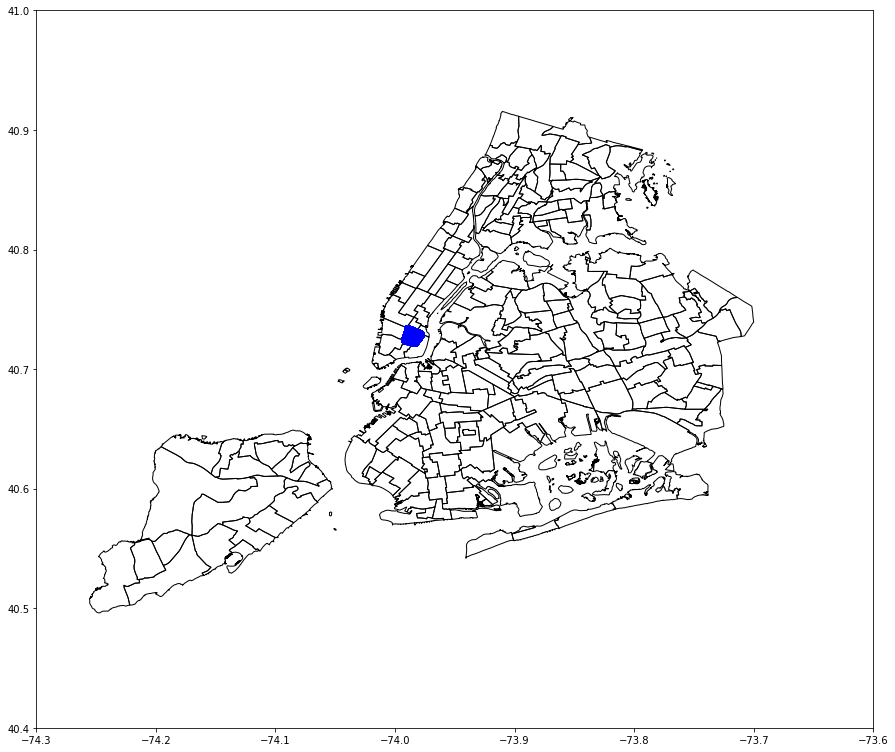

In [9]:
plotNeighborhood(selectedNeighborhood)

**ridesInSelectedNeighborhood** - a filtered DataFrame containing the ride counts per hour in the selected neighborhood

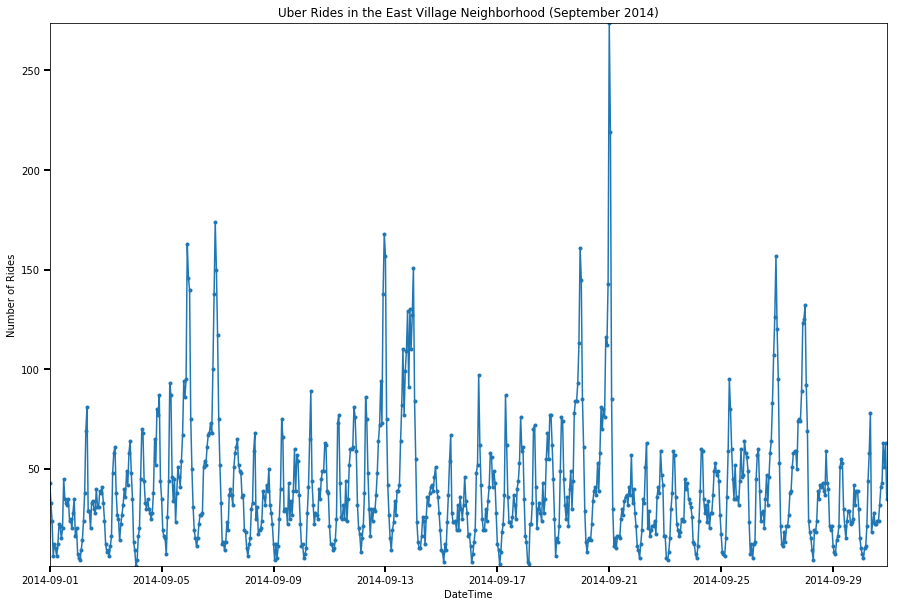

In [10]:
ridesInSelectedNeighborhood = ridesPerNeighborhood[ridesPerNeighborhood['neighborhood'] == selectedNeighborhood]
ridesInSelectedNeighborhood = ridesInSelectedNeighborhood.drop(columns='neighborhood')
ridesInSelectedNeighborhood = ridesInSelectedNeighborhood.reset_index(drop=True)
plotRides(
    ridesInSelectedNeighborhood['pickupDateTime'], 
    ridesInSelectedNeighborhood['count'],
    selectedNeighborhood,
    'September 2014'
)

# SARIMA forecasting
* As seen in the plot above, there are recurring seasonal aspects to the plot with relative peaks observed during the night hours as well as during weekends
* The Seasonal Autoregressive Integrated Moving Average (SARIMA) model is effective at forecasting univariate time series data that contain seasonal components [1]
* This model was selected because of the seasonal nature of this time series dataset

## Defining SARIMA hyperparamaters
Configuring a SARIMA model requires selecting hyperparameters for both the trend and seasonal elements of the series

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.
    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.

The following line will perform a grid search of all (324) possible combinations of hyperparameters to find the optimal configuration as described in [2]. The optimal hyperparameter configuration is identified by having the lowest Root Mean Square Error (RMSE) when comparing the modeled fit against the test data (consisting of the last 24 hours of the dataset).

In [ ]:
data = ridesInSelectedNeighborhood['count']
cfg_list = sarima_configs([24]) # period is set to 24 for this dataset because ride counts are aggregated on an hourly basis
scores = grid_search(data, cfg_list, 24, True)

for cfg, error in scores[:3]:
    print(cfg, error)

 > 2019-03-11 22:44:14 Model[[(0, 0, 0), (0, 0, 0, 24)]] 36.810
 > 2019-03-11 22:44:16 Model[[(0, 0, 0), (0, 1, 0, 24)]] 11.563
 > 2019-03-11 22:44:17 Model[[(0, 0, 0), (1, 0, 0, 24)]] 14.968
 > 2019-03-11 22:44:24 Model[[(0, 0, 0), (1, 1, 0, 24)]] 12.585
 > 2019-03-11 22:44:25 Model[[(0, 0, 0), (1, 0, 1, 24)]] 15.001
 > 2019-03-11 22:44:34 Model[[(0, 0, 0), (0, 0, 1, 24)]] 21.914
 > 2019-03-11 22:44:47 Model[[(0, 0, 0), (2, 0, 0, 24)]] 15.038


## Forecasting October 2014 rides using SARIMA model
Train/ fit the SARIMA model using the optimal hyperparameter configuration identified above. The m variable is set to 168 (hours) here to better capture the seasonal behavior of ride counts over an entire *week*

In [ ]:
print('Begin fitting: ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

my_order = (1, 0, 0) # model trend configuration (pdq)
my_seasonal_order = (1, 1, 0, 168) # model seasonal trend configuration (PDQm)

model = SARIMAX(
    data, 
    order = my_order,
    seasonal_order=my_seasonal_order
    #,enforce_stationarity = False
    #,enforce_invertibility = False
)

model_fit = model.fit()

print('Complete fitting: ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Forecast the next month (744 hours) of uber ride counts per hour

In [ ]:
print('Begin forecasting: ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

yhat = round(model_fit.predict(start=len(data), end=len(data)+744)).astype(int)

print('Complete forecasting: ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

d = []
for i in range(len(yhat)-1):
    d.append({'pickupDateTime': max(ridesInSelectedNeighborhood['pickupDateTime']) + timedelta(hours=i+1),
            'count': yhat.iloc[i]})

octRidesInSelectedNeighborhood = pd.DataFrame(d)
plotRides(
    octRidesInSelectedNeighborhood['pickupDateTime'], 
    octRidesInSelectedNeighborhood['count'],
    selectedNeighborhood,
    'October 2014'
)

In [ ]:
print(octRidesInSelectedNeighborhood)

## References
[1] https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/  
[2] https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/